In this competition, Zillow is asking us to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. 
The log error is defined as:
                            logerror=log(Zestimate)−log(SalePrice)
As per of this project, we predicted the logerror for the months in Fall 2016. 
We implemented steps like data visualization, data quality, EDA, various machine learning algorithms implementation,  hyperparameter tuning, model’s assumption checking, and error matrix analysis.

The notebook covers Following Topics:

- Missing Value Analysis
- Correlation Analysis
- Top Contributing Features (Through XGBoost)
- Correlation Analysis
- Multicollinearity Analysis
- Univariate Analysis
- Bivariate Analysis
- Missing value filling using KNN algorithm
- Supervised Learning algorithms to predict "logerror"
- Hyperparameter Tunning


In [72]:
import numpy as np # linear algebra
from numpy.distutils.system_info import numpy_info
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from ggplot import *
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import explained_variance_score,accuracy_score, r2_score

- parcelid (Id which represents parcel)
- logerror (logerror = log(zestimate) - log(salesprice))
- transactiondate (Date at which the property got sold out)

In [2]:
train_df_temp = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
train_df_temp.shape

(90275, 3)

Target variable for this competition is 'logerror'. Below graph shows how logerror scattered scross all the data points.

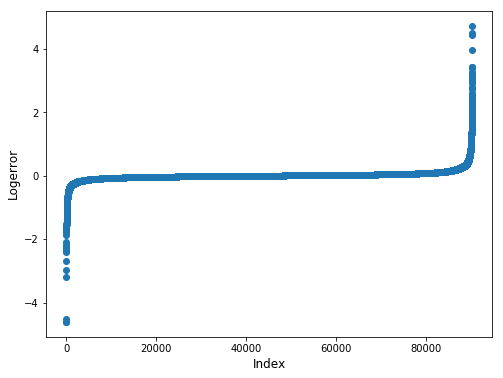

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df_temp.shape[0]), np.sort(train_df_temp.logerror.values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Logerror', fontsize=12)
plt.show()

Below code will remove the outliers for target variable logerror. The code will set the upper limit as 99 percentile and lower limit as 1 percentile to remove the outliers. It also create the scatter plot which shows the normal distrubution of the logerro variable. 

C:\Users\kahma\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


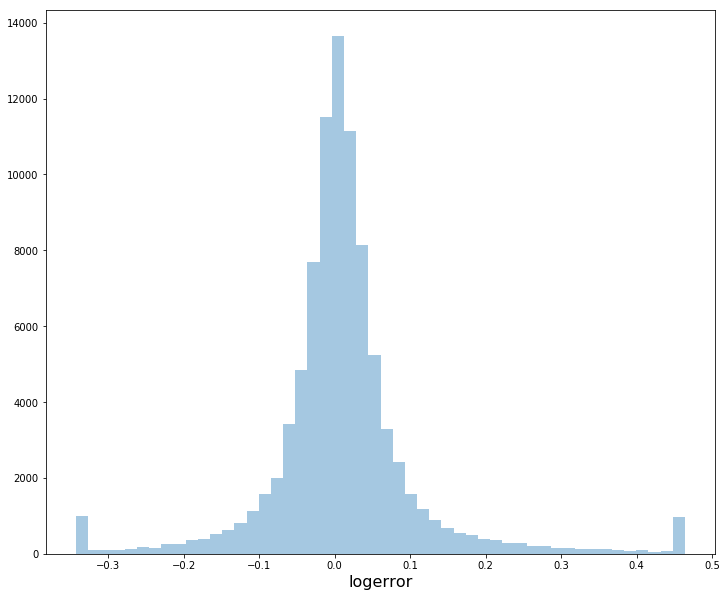

In [4]:
ulimit = np.percentile(train_df_temp.logerror.values, 99)
llimit = np.percentile(train_df_temp.logerror.values, 1)
train_df_temp.logerror.loc[train_df_temp['logerror'] > ulimit] = ulimit
train_df_temp.logerror.loc[train_df_temp['logerror'] < llimit] = llimit

plt.figure(figsize=(12, 10))
sns.distplot(train_df_temp.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=16)
plt.show()

Below graph shows the distrubution of the data points based on the transaction months. It shows the number of properties sold out for each month available in the dataset.

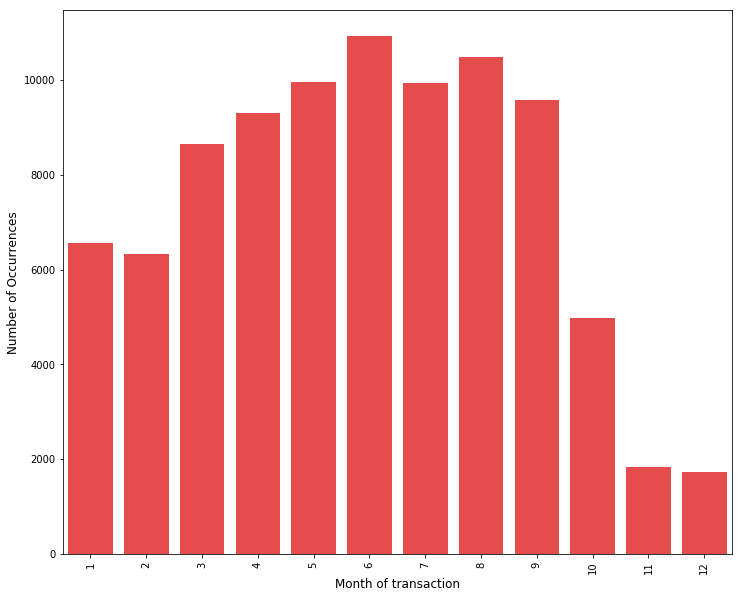

In [5]:
train_parcel_data = train_df_temp
train_parcel_data['transaction_month'] = train_parcel_data['transactiondate'].dt.month

cnt_srs = train_parcel_data['transaction_month'].value_counts()
plt.figure(figsize=(12, 10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='red')
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()
train_parcel_data.drop(['transaction_month'], axis=1, inplace = True)

In the above graph, as we could see, we have shorter bars in the last three months since the train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

Most of the parcel ids are unique and appear only once in the dataset

In [6]:
(train_parcel_data['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

# Exploring the properties_2016 file:

"properties_2016_10k.csv" file contains data related to the property available from the zillow database along with the attributes associated with it.

In [7]:
prop_df = pd.read_csv("properties_2016_10k.csv")
prop_df.shape

(10000, 59)

Lets count the number of missing values in each column first.

In [8]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')

There are so many NaN values in the dataset.

In [9]:
missing_df

,column_name,missing_count
54,taxamount,1
39,regionidzip,3
50,structuretaxvaluedollarcnt,30
11,calculatedfinishedsquarefeet,68
57,censustractandblock,71
47,yearbuilt,78
8,calculatedbathnbr,117
19,fullbathcnt,117
36,regionidcity,201
12,finishedsquarefeet12,460


Below code type cast all float64 columns to float32 to shrink the size of the dataset.
It also merge the dataset from "train_2016_v2.csv" file and "properties_2016_10k.csv" based on parcelid.

In [10]:
for clm, dtype in zip(prop_df.columns, prop_df.dtypes):
    if dtype == np.float64:
        prop_df[clm] = prop_df[clm].astype(np.float32)
train_df = prop_df.merge(train_df_temp, how='left', on='parcelid')

del train_df_temp, prop_df, train_parcel_data
train_df.drop(['transactiondate'], axis=1, inplace=True)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10034 entries, 0 to 10033
Data columns (total 60 columns):
parcelid                        10034 non-null int64
airconditioningtypeid           3184 non-null float32
architecturalstyletypeid        24 non-null float32
basementsqft                    5 non-null float32
bathroomcnt                     10034 non-null float32
bedroomcnt                      10034 non-null int64
buildingclasstypeid             2 non-null float32
buildingqualitytypeid           6378 non-null float32
calculatedbathnbr               9915 non-null float32
decktypeid                      75 non-null float32
finishedfloor1squarefeet        760 non-null float32
calculatedfinishedsquarefeet    9964 non-null float32
finishedsquarefeet12            9568 non-null float32
finishedsquarefeet13            3 non-null float32
finishedsquarefeet15            362 non-null float32
finishedsquarefeet50            760 non-null float32
finishedsquarefeet6             31 non-null 

We have calculated the mean for each columns and replaced all null value with mean value for respective column. The reason behind doingmean for the collumn is to get rid of null value with appropriate value for that column.

In [12]:
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values)

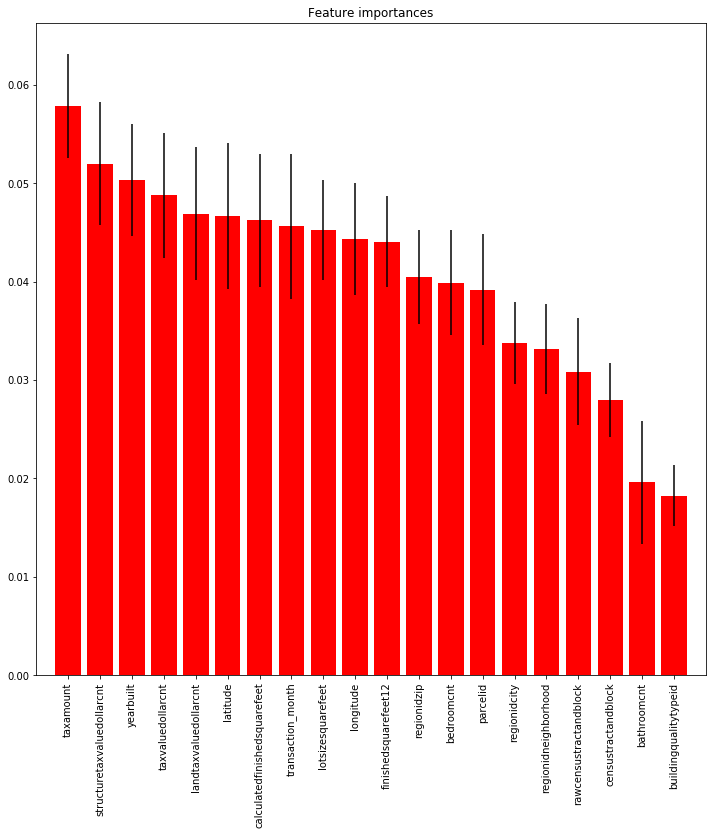

In [13]:
train_df_new_y = train_df_new['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df_new = train_df_new.drop(['logerror']+cat_cols, axis=1)
feat_names = train_df_new.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df_new, train_df_new_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Below graph to show the important feature from the dataset by removing all categorical features using XGBoost algorithm.

[20:19:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:19:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:19:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:19:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:19:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:19:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:19:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

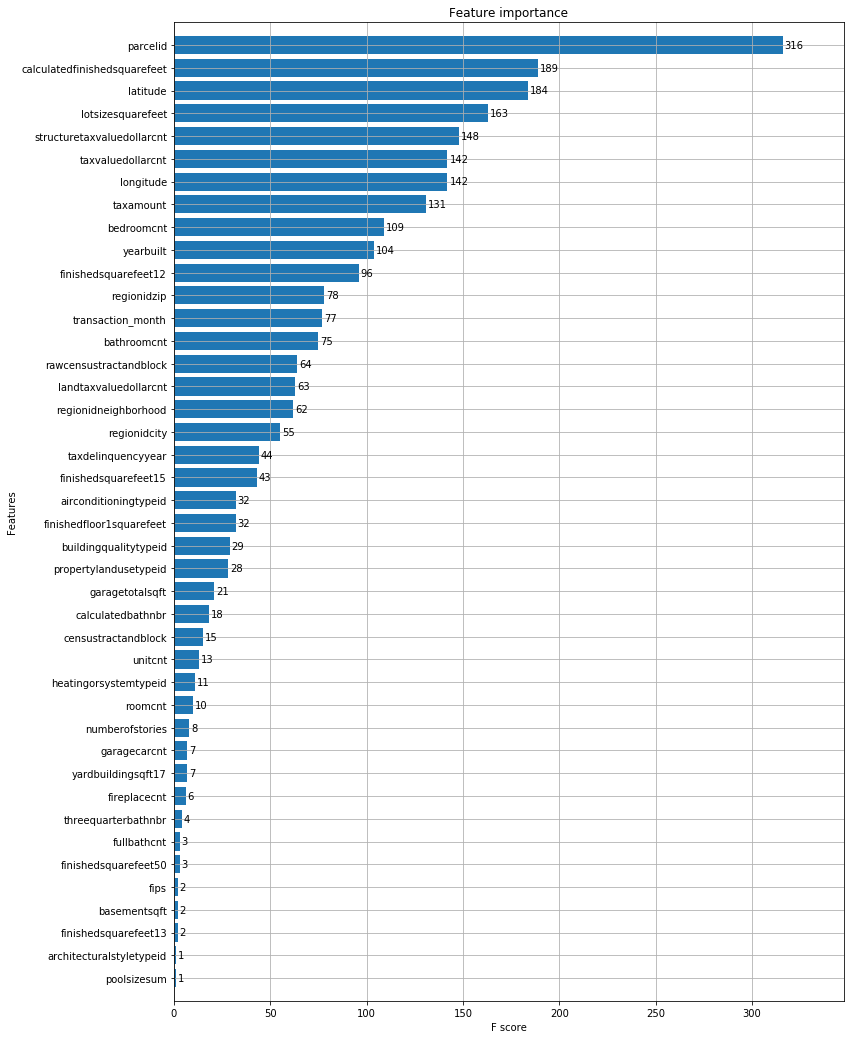

In [14]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed': 0
}
dtrain = xgb.DMatrix(train_df_new, train_df_new_y, feature_names=train_df_new.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12, 18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

From the above graph, we could choose few feature to remove form the dataset which don't have importance.

In [15]:
dropcols = ['finishedsquarefeet13', 'fullbathcnt','finishedsquarefeet15','finishedsquarefeet6','finishedsquarefeet50','calculatedbathnbr']

In [16]:
def variation(col, col_name, title):
    ulimit = np.percentile(col.values, 99.5)
    llimit = np.percentile(col.values, 0.5)
    col.ix[col > ulimit] = ulimit
    col.ix[col < llimit] = llimit

    plt.figure(figsize=(12,12))
    sns.jointplot(x=col.values, y=train_df.logerror.values, size=10, color='blue')
    plt.ylabel('Log Error', fontsize=12)
    plt.xlabel(col_name, fontsize=12)
    plt.title(title, fontsize=15)
    plt.show()

C:\Users\kahma\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\kahma\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\kahma\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\kahma\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional

<Figure size 864x864 with 0 Axes>

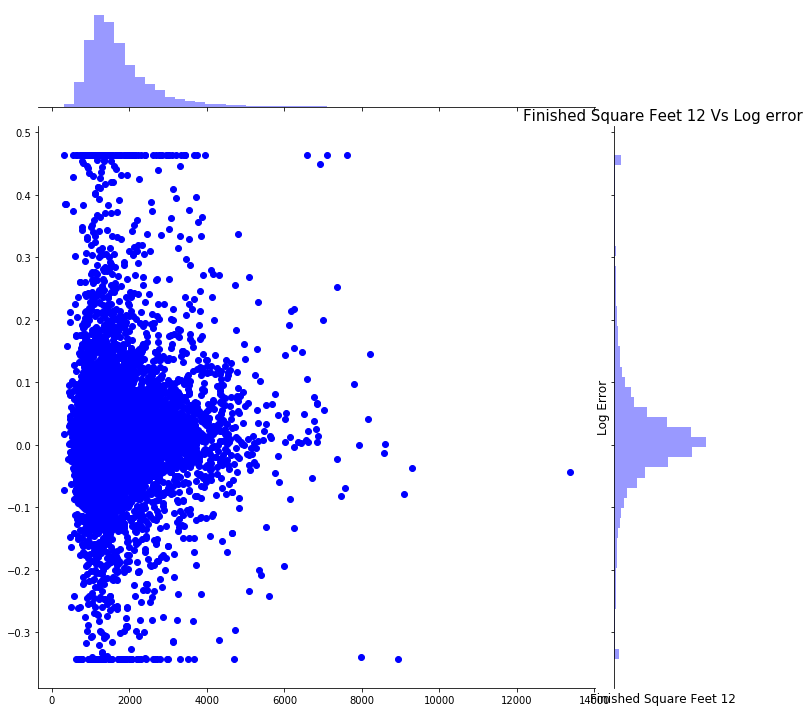

C:\Users\kahma\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

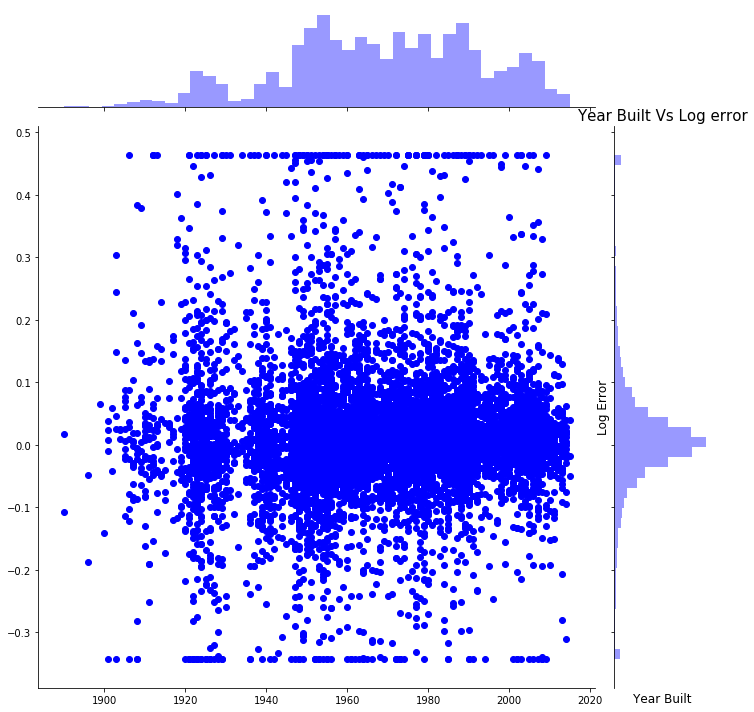

C:\Users\kahma\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

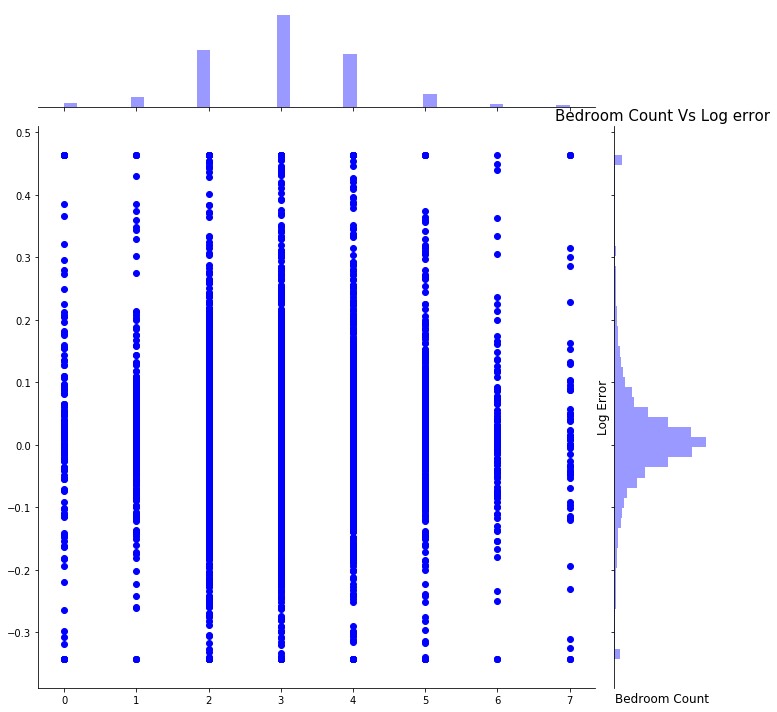

C:\Users\kahma\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

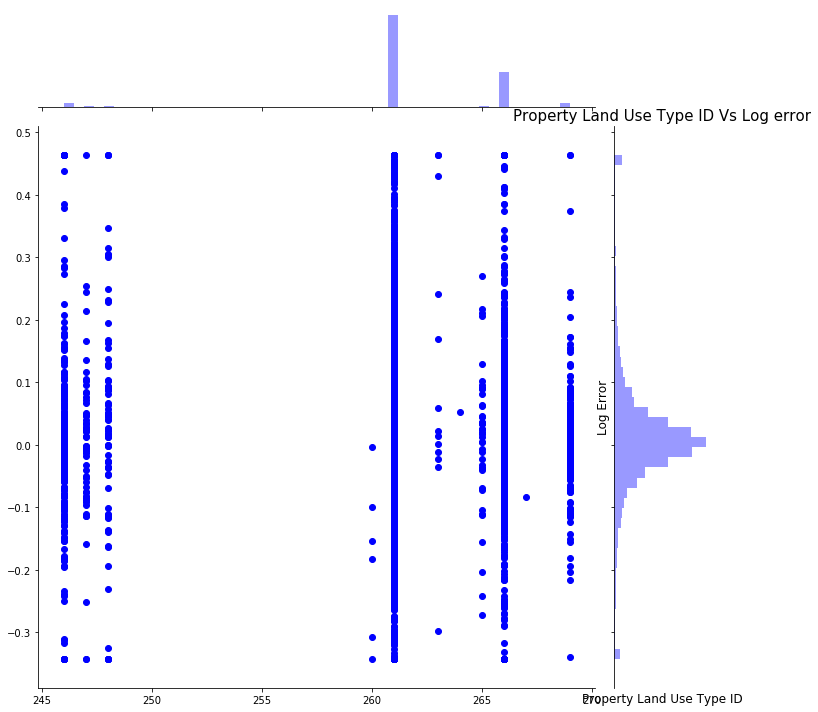

In [17]:
variation(train_df.finishedsquarefeet12, 'Finished Square Feet 12', "Finished Square Feet 12 Vs Log error")

variation(train_df.yearbuilt, 'Year Built', "Year Built Vs Log error")

variation(train_df.bedroomcnt, 'Bedroom Count', "Bedroom Count Vs Log error")

variation(train_df.propertylandusetypeid, 'Property Land Use Type ID', "Property Land Use Type ID Vs Log error")

Checking the fequency of bathroom count in the current dataset.

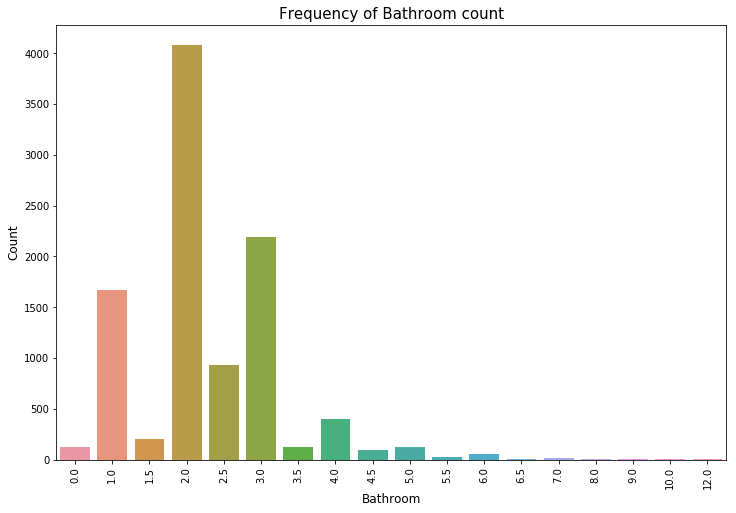

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

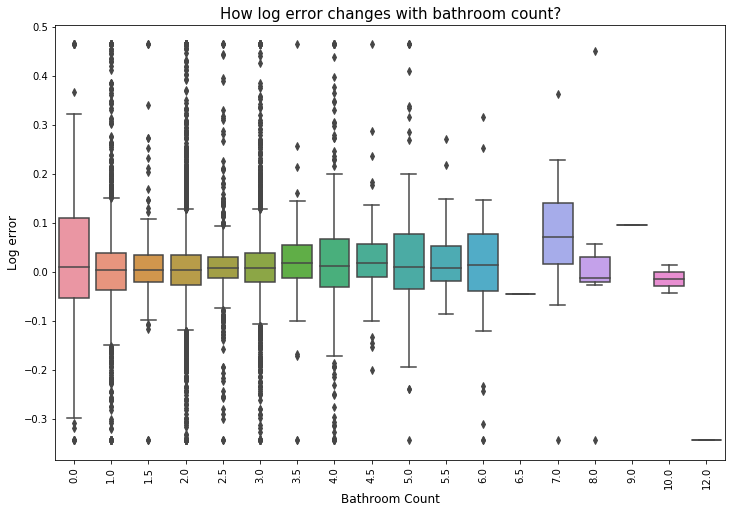

In [19]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

Below graph shows the frequency of bedroom count.

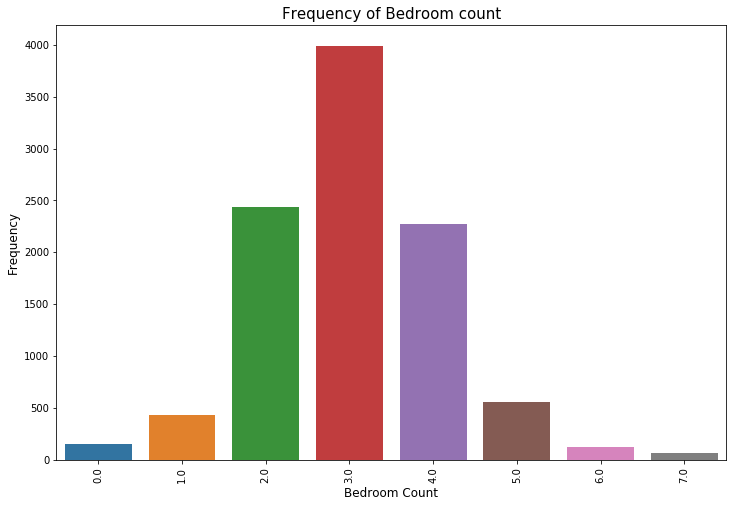

In [20]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

Below graph shows how logerror changes on bedroom count feature.

C:\Users\kahma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\kahma\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\kahma\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a d

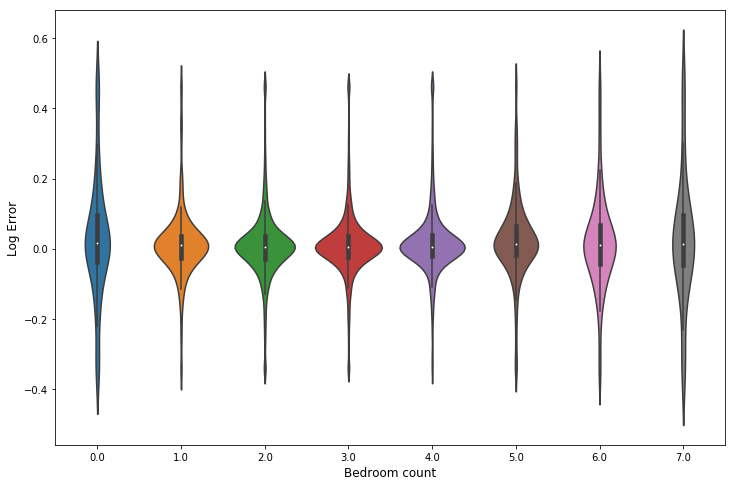

In [21]:
train_df['bedroomcnt'].ix[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

Below plot shows the distribution of housing property geographically.

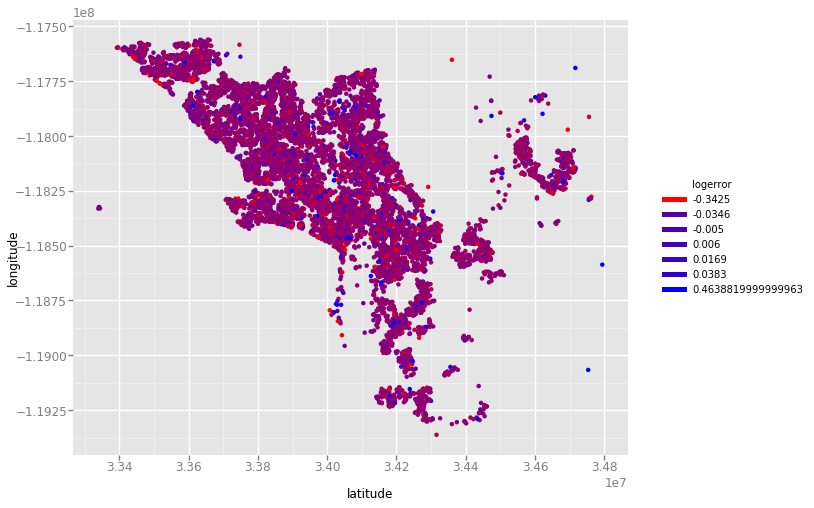

<ggplot: (139898848439)>

In [22]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')


Lets begin with analysis of missing values to figure out a way to handle them

In [23]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column_Type"]
dtype_df.groupby("Column_Type").aggregate('count').reset_index()

,Column_Type,Count
0,int64,11
1,float32,41
2,float64,3
3,object,5


number of column with different datatype.

Below graph shows the number of Null values for each columns.

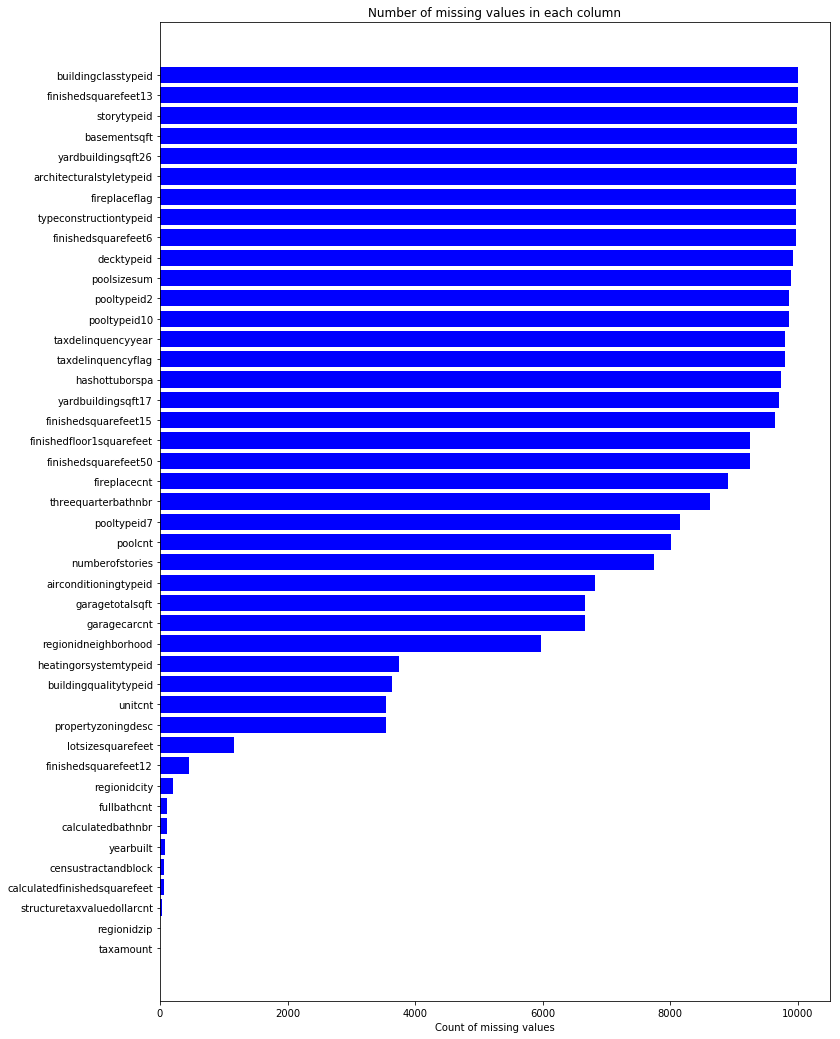

In [24]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Basic null value replacement for the dataset.

In [25]:
values = {'hashottuborspa': "None", 'fireplacecnt': 0,'pooltypeid2': 0, 'pooltypeid7': 0, 'poolcnt':'0', 'taxdelinquencyflag': "None", 'garagecarcnt': 0, 'garagetotalsqft' : 0, 'airconditioningtypeid' : 1, 'heatingorsystemtypeid' : 2, 'threequarterbathnbr':1}
train_df.fillna(value=values, inplace=True)
#train_df.info()

Column "hashottuborspa" and "pooltypeid10" have same information in the dataset as per the disciprion give in the kaggle which means it contains the redundant data.

In [26]:
print(train_df.hashottuborspa.value_counts())
print(train_df.pooltypeid10.value_counts())

dropcols.append('pooltypeid10')

None    9774
True     260
Name: hashottuborspa, dtype: int64
1.0    130
Name: pooltypeid10, dtype: int64


I have taken median of the "poolsizesum" column for the rows where "poolcnt" is not zero.
We will replace this median value to the null value in the column"poolsizesum" where "poolcnt" column is not zero. Rest of the rows for "poolsizesum" will be assigned as zero.

In [27]:
train_df.poolcnt = train_df.poolcnt.astype('int32')
poolsizemedian = train_df.loc[train_df['poolcnt'] > 0, 'poolsizesum'].median()
train_df.loc[(train_df['poolcnt'] > 0) & (train_df['poolsizesum'].isnull()), 'poolsizesum'] = poolsizemedian
train_df.loc[train_df['poolcnt'] > 0, 'poolsizesum'] = 0

Fireplace flag will be "yes" for the rows whose "fireplacecnt" column is not zero. Rest of the rows for "fireplaceflag" will be "No".

In [28]:
train_df['fireplaceflag'] = "No"
train_df.loc[train_df['fireplacecnt'] > 0,'fireplaceflag'] = "Yes"

Removing the columns whose having null values more than 97% of the total values.

In [29]:
missing_values_prop = (train_df.isnull().sum()/len(train_df)).reset_index()
missing_values_prop.columns = ['Column_Name', 'proportion']
missing_values_prop.sort_values(by='proportion', ascending=False, inplace=True)
missing_prop_cols = missing_values_prop[missing_values_prop['proportion'] > 0.97].Column_Name.tolist()

Below function is to build knn algorithm which can help us to predict the correct value which is missing in the dataset. The reason behind using KNN algorithm is that it predict appropriate values for the null values of the geographical features using latitude and longitude. We have also shown in the function that how well the KNN algorithm has predicted the null value for various features related to the geography of any house.

In [30]:
# we have to drop any rows which contain null value in latitude or longitude column. 
train_df.dropna(axis=0, how='any', subset=['latitude', 'longitude'], inplace=True)


def fillna_value_using_knn(base, target, fraction=1, thresold=10, n_neighbors=5):
    assert isinstance(base, list) or isinstance(base, np.ndarray) and isinstance(target, string)
    whole = [target] + base
    
    ms = train_df[target].isnull()
    notms = ~ms
    numms = ms.sum()
    print("Number of missing value", numms)
    #enc = OneHotEncoder()
    model_data = train_df.loc[notms, whole]
    x1_train, x1_test, y1_train, y1_test = train_test_split(model_data[base], model_data[target], test_size=fraction)
    #enc.fit(x_target[target].unique().reshape((-1, 1)))
    
    #y = enc.transform(x_target[target].values.reshape((-1, 1))).toarray()
    #y = x_target[target]
    #x = x_target[base]
    #print(y)
    #print('knn neighbors')
    clf = KNeighborsClassifier(n_neighbors, weights='uniform')
    clf.fit(x1_train, y1_train)
    y1_predict = clf.predict(x1_test)
    score = clf.score(x1_test, y1_test)
    #print("Accuracy for the model", score)
    print("Accuracy:",metrics.accuracy_score(y1_test, y1_predict))
    
    actual_predict = clf.predict(train_df.loc[ms, base])    
    #print("Actual Predicted",actual_predict)    
    numpredict = len(actual_predict)
    
    if score*100 > 50:
        print('write result to df')
        train_df.loc[ms, target] = np.array(actual_predict)
        print('num of unpredicted data:', numpredict)
    else:
        print('out of thresold')

In [31]:
fillna_value_using_knn(base=['latitude', 'longitude'], target='buildingqualitytypeid', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(base=['latitude', 'longitude'], target='regionidcity', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(base=['latitude', 'longitude'], target='regionidneighborhood', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(base=['latitude', 'longitude'], target='regionidzip', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(base=['latitude', 'longitude'], target='unitcnt', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(base=['latitude', 'longitude'], target='yearbuilt', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(base=['latitude', 'longitude'], target='lotsizesquarefeet', fraction=0.15, n_neighbors=1)

Number of missing value 3656
Accuracy: 0.6729362591431557
write result to df
num of unpredicted data: 3656
Number of missing value 203
Accuracy: 0.9464406779661017
write result to df
num of unpredicted data: 203
Number of missing value 5993
Accuracy: 0.8929159802306426
write result to df
num of unpredicted data: 5993
Number of missing value 3
Accuracy: 0.9189368770764119
write result to df
num of unpredicted data: 3
Number of missing value 3555
Accuracy: 0.9228395061728395
write result to df
num of unpredicted data: 3555
Number of missing value 80
Accuracy: 0.21887550200803213
out of thresold
Number of missing value 1161
Accuracy: 0.06836964688204357
out of thresold


In [32]:
train_df.loc[(train_df['finishedfloor1squarefeet'].isnull()) & (train_df['numberofstories'] == 1), 'finishedfloor1squarefeet'] = train_df.loc[(train_df['finishedfloor1squarefeet'].isnull()) & (train_df['numberofstories'] == 1), 'calculatedfinishedsquarefeet']

droprows = train_df.loc[train_df['calculatedfinishedsquarefeet'] < train_df['finishedfloor1squarefeet']].index
train_df = train_df.drop(droprows)

train_df.loc[train_df.taxvaluedollarcnt.isnull(), 'taxvaluedollarcnt'] = train_df.loc[train_df.taxvaluedollarcnt.isnull(), 'taxamount']
train_df.loc[train_df.landtaxvaluedollarcnt.isnull(), 'landtaxvaluedollarcnt'] = train_df.loc[train_df.landtaxvaluedollarcnt.isnull(), 'taxamount']

In [33]:
dropcols += missing_prop_cols
print(dropcols)

drop_unimp_cols = ['finishedfloor1squarefeet', 'propertycountylandusecode', 'poolsizesum', 'propertyzoningdesc', 'numberofstories']
dropcols += drop_unimp_cols
train_df.drop(dropcols, axis=1, inplace=True)

['finishedsquarefeet13', 'fullbathcnt', 'finishedsquarefeet15', 'finishedsquarefeet6', 'finishedsquarefeet50', 'calculatedbathnbr', 'pooltypeid10', 'buildingclasstypeid', 'finishedsquarefeet13', 'basementsqft', 'storytypeid', 'yardbuildingsqft26', 'architecturalstyletypeid', 'typeconstructiontypeid', 'finishedsquarefeet6', 'decktypeid', 'pooltypeid10', 'taxdelinquencyyear', 'yardbuildingsqft17']


drop rows for the null value of "yearbuilt" column and fill mean values for the null entries in other column.

In [34]:
train_df.dropna(axis=0, subset=['yearbuilt'], inplace=True)
df_mean = train_df.mean()
train_df = train_df.fillna(df_mean)

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 10033
Data columns (total 39 columns):
parcelid                        9954 non-null int64
airconditioningtypeid           9954 non-null float32
bathroomcnt                     9954 non-null float32
bedroomcnt                      9954 non-null float64
buildingqualitytypeid           9954 non-null float32
calculatedfinishedsquarefeet    9954 non-null float32
finishedsquarefeet12            9954 non-null float32
fips                            9954 non-null int64
fireplacecnt                    9954 non-null float32
garagecarcnt                    9954 non-null float32
garagetotalsqft                 9954 non-null float32
hashottuborspa                  9954 non-null object
heatingorsystemtypeid           9954 non-null float32
latitude                        9954 non-null int64
longitude                       9954 non-null int64
lotsizesquarefeet               9954 non-null float32
poolcnt                         9954 

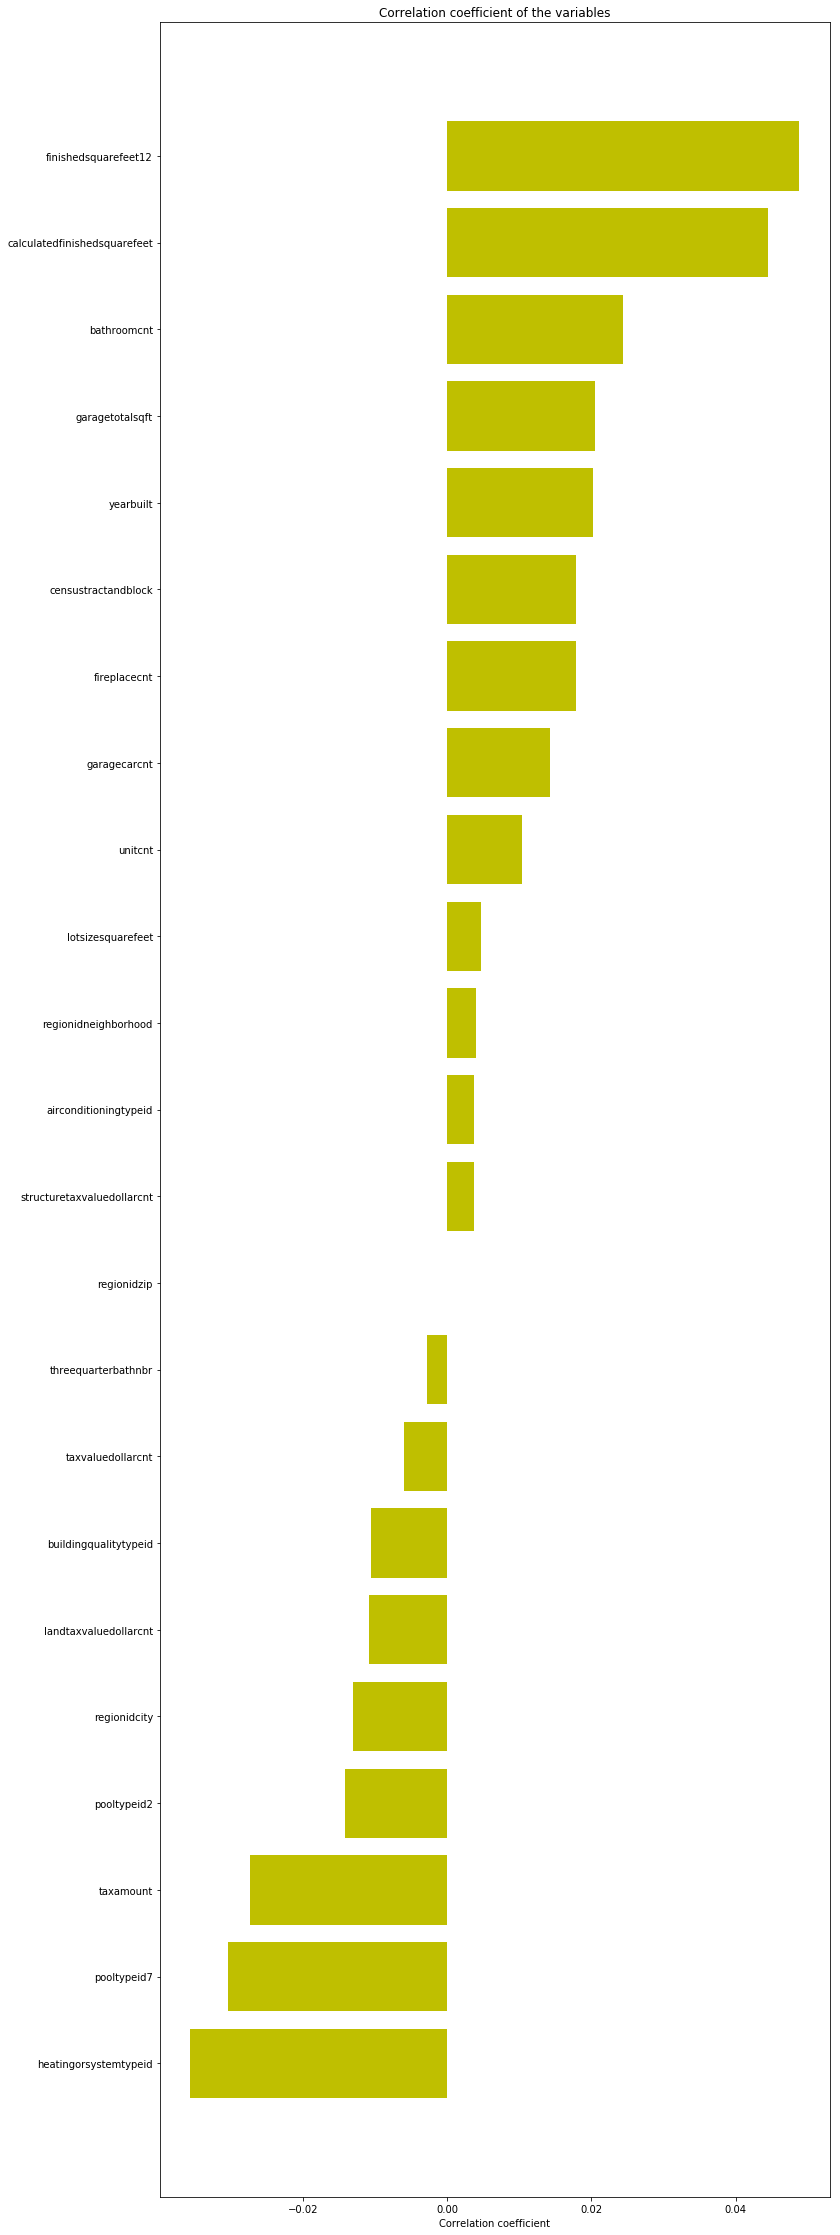

In [36]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float32']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels': labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
#train_df.head()
#corr_df.head()
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

Lets figure out variables with high correlation and then do some analysis on them.

In [37]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

C:\Users\kahma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,col_labels,corr_values
8,heatingorsystemtypeid,-0.035569
11,pooltypeid7,-0.030387
21,taxamount,-0.027266
10,pooltypeid2,-0.014205
12,regionidcity,-0.013000
20,landtaxvaluedollarcnt,-0.010759
2,buildingqualitytypeid,-0.010573
17,yearbuilt,0.020215
7,garagetotalsqft,0.020473
1,bathroomcnt,0.024318


In [38]:
sample_df= train_df.isnull().sum(axis=0).reset_index()
sample_df.columns = ['column_name','cnt']
sample_df = sample_df.loc[sample_df['cnt']>=0]
print(sample_df.column_name.values)

['parcelid' 'airconditioningtypeid' 'bathroomcnt' 'bedroomcnt'
 'buildingqualitytypeid' 'calculatedfinishedsquarefeet'
 'finishedsquarefeet12' 'fips' 'fireplacecnt' 'garagecarcnt'
 'garagetotalsqft' 'hashottuborspa' 'heatingorsystemtypeid' 'latitude'
 'longitude' 'lotsizesquarefeet' 'poolcnt' 'pooltypeid2' 'pooltypeid7'
 'propertylandusetypeid' 'rawcensustractandblock' 'regionidcity'
 'regionidcounty' 'regionidneighborhood' 'regionidzip' 'roomcnt'
 'threequarterbathnbr' 'unitcnt' 'yearbuilt' 'fireplaceflag'
 'structuretaxvaluedollarcnt' 'taxvaluedollarcnt' 'assessmentyear'
 'landtaxvaluedollarcnt' 'taxamount' 'taxdelinquencyflag'
 'censustractandblock' 'transaction_month' 'logerror']


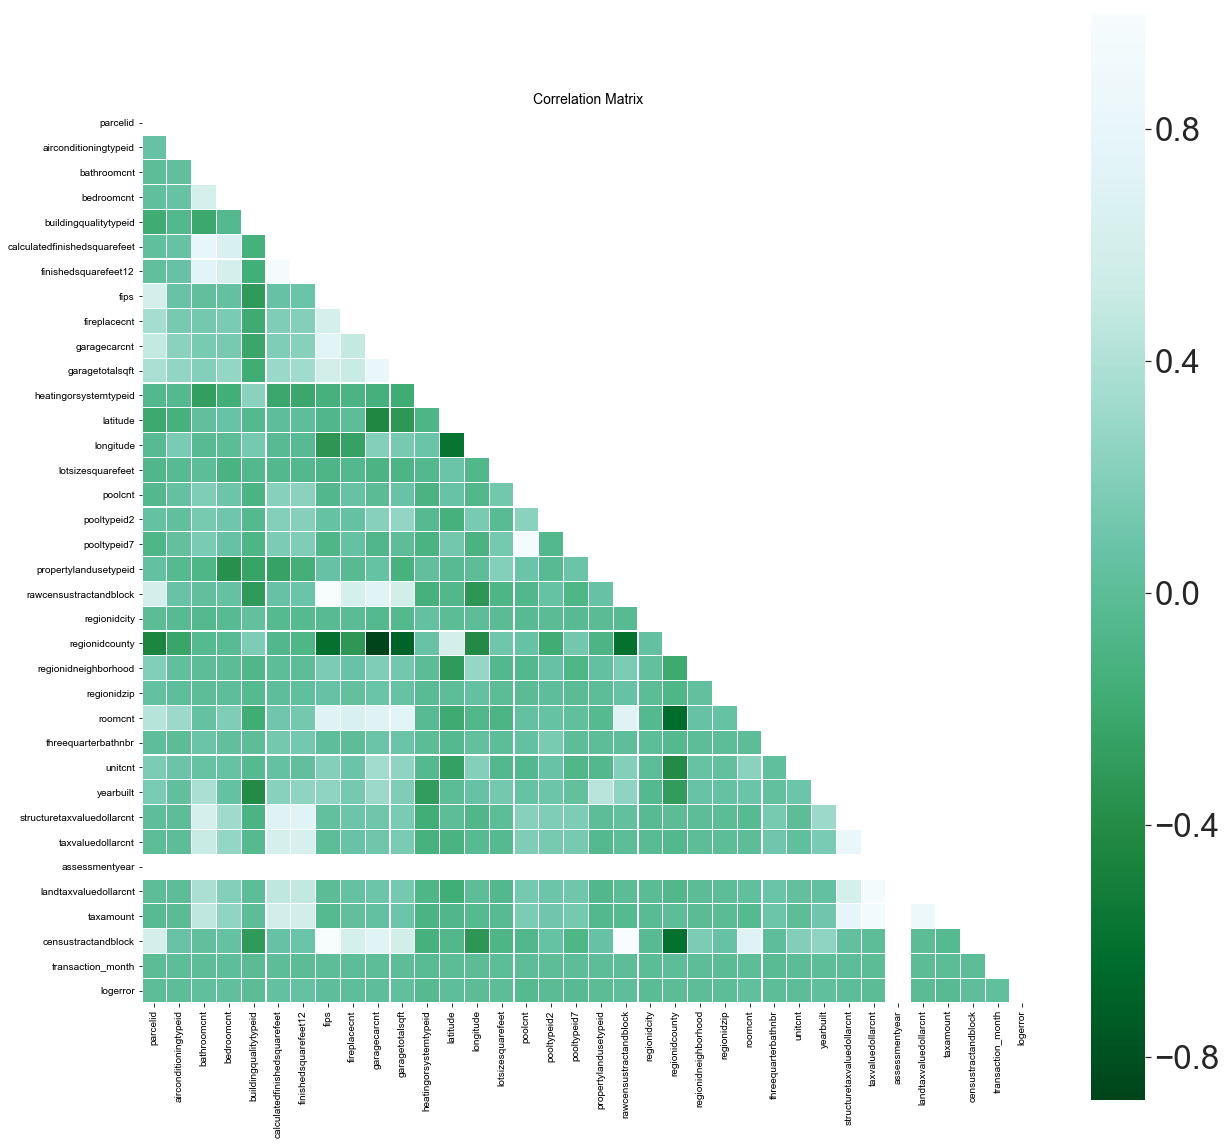

In [39]:
mask = np.zeros_like(train_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(20, 20))
plt.title('Correlation Matrix', fontsize=14)
sns.set(font_scale=3)
sns.heatmap(train_df.corr(), linewidths=0.25, vmax=1.0, square=True, cmap="BuGn_r", mask=mask, linecolor='w', cbar={"shrink":.75})

In [40]:
drop_corr_columns = ['fips','fireplacecnt','garagetotalsqft','assessmentyear','heatingorsystemtypeid','censustractandblock','unitcnt','roomcnt','garagecarcnt','threequarterbathnbr','heatingorsystemtypeid']
train_df.drop(drop_corr_columns, axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 10033
Data columns (total 29 columns):
parcelid                        9954 non-null int64
airconditioningtypeid           9954 non-null float32
bathroomcnt                     9954 non-null float32
bedroomcnt                      9954 non-null float64
buildingqualitytypeid           9954 non-null float32
calculatedfinishedsquarefeet    9954 non-null float32
finishedsquarefeet12            9954 non-null float32
hashottuborspa                  9954 non-null object
latitude                        9954 non-null int64
longitude                       9954 non-null int64
lotsizesquarefeet               9954 non-null float32
poolcnt                         9954 non-null int32
pooltypeid2                     9954 non-null float32
pooltypeid7                     9954 non-null float32
propertylandusetypeid           9954 non-null float64
rawcensustractandblock          9954 non-null int64
regionidcity                    9954 no

We have distrubuted the dataset into train and test datapoint based on the months. From Jan-2016 to Sept-2016 data will be used to train the model and From Oct-2016 to Dec-2018 data will be used to test the model and get the prediction. 

In [41]:
train_sample = train_df
dummy_columns = ["hashottuborspa", "fireplaceflag", "taxdelinquencyflag"]
df_clean = pd.get_dummies(train_df, columns=dummy_columns)

In [42]:
train_data = df_clean[df_clean['transaction_month'] < 10]
test_data = df_clean[df_clean['transaction_month'] > 9]

In [43]:
train_data_x1 = train_data.drop(['parcelid', 'logerror', 'transaction_month'], axis=1)
train_data_y1 = train_data['logerror']

test_data_x1 = test_data.drop(['parcelid', 'logerror', 'transaction_month'], axis=1)
test_data_y1 = test_data['logerror']

In [44]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'n_estimators': [500, 1000],
    'loss': ['ls', 'lad', 'huber', 'quantile']
    }
grd_regr = GradientBoostingRegressor()
grid_grad_boost = GridSearchCV(grd_regr, param_grid, n_jobs=4)
grid_grad_boost.fit(train_data_x1, train_data_y1)
print(grid_grad_boost.best_score_)
print(grid_grad_boost.best_params_)

0.010888618390871038
{'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 17, 'n_estimators': 500}


In [46]:
grd_regr = GradientBoostingRegressor(max_depth=4, loss='ls', learning_rate=0.01, min_samples_leaf = 17, n_estimators=500)
grd_regr.fit(train_data_x1, train_data_y1)
y1_pred_grd = grd_regr.predict(test_data_x1)
print(grd_regr.score(test_data_x1, test_data_y1))


-0.013576765076313224


In [77]:
print("RMSE: %.2f" % math.sqrt(np.mean((grd_regr.predict(test_data_x1) - test_data_y1) ** 2)))
print(explained_variance_score(test_data_y1, y1_pred_grd))

RMSE: 0.10
-0.0022776710510874487


In [49]:
param_ada_grid = {
    'loss': ['linear', 'square', 'exponential'],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'n_estimators': [500, 1000]
}

ada_boost_mdl = AdaBoostRegressor()
grid_ada_boost = GridSearchCV(ada_boost_mdl, param_ada_grid)
grid_ada_boost.fit(train_data_x1, train_data_y1)
print(grid_ada_boost.best_params_)
print(grid_ada_boost.best_score_)

{'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
-0.00489471699111325


In [50]:
ada_best_param_mdl = AdaBoostRegressor(loss='exponential', learning_rate=0.01, n_estimators=500)
ada_best_param_mdl.fit(train_data_x1, train_data_y1)
y1_pred_ada = ada_best_param_mdl.predict(test_data_x1)
print(ada_best_param_mdl.score(test_data_x1, test_data_y1))

0.003109105979276938


In [79]:
print("RMSE: %.2f" % math.sqrt(np.mean((ada_best_param_mdl.predict(test_data_x1) - test_data_y1) ** 2)))
print(explained_variance_score(test_data_y1, y1_pred_ada))

RMSE: 0.10
0.0032013274424348426


In [52]:
xgb_params = {'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9]}
xgb_mdl = xgb.XGBRegressor()
grid_xgb = GridSearchCV(xgb_mdl, xgb_params)
grid_xgb.fit(train_data_x1, train_data_y1)
print(grid_xgb.best_score_)
print(grid_xgb.best_params_)

0.0007426097567100335
{'max_depth': 3, 'n_estimators': 100}


In [56]:
xgb_best_mdl = xgb.XGBRegressor(max_depth=3, n_estimators= 100)
xgb_best_mdl.fit(train_data_x1, train_data_y1)
y1_pred_xgb = xgb_best_mdl.predict(test_data_x1)
print(xgb_best_mdl.score(test_data_x1, test_data_y1))

-0.01980860464678358


In [80]:
print("RMSE: %.5f" % math.sqrt(np.mean((xgb_best_mdl.predict(test_data_x1) - test_data_y1) ** 2)))
print(explained_variance_score(test_data_y1, y1_pred_xgb))

RMSE: 0.09781
-0.008812761913210787


In [58]:
parm_grid_rnd = {
    'n_estimators': [5, 10, 15],
    'n_jobs': [-1],
    'oob_score': [False]
}
rand_forest_grd_mdl = RandomForestRegressor()
grid_rand_forest = GridSearchCV(rand_forest_grd_mdl, parm_grid_rnd)
grid_rand_forest.fit(train_data_x1, train_data_y1)

cv_results = pd.DataFrame(grid_rand_forest.cv_results_)
print(cv_results[["param_n_estimators","mean_test_score","std_test_score"]])

print(grid_rand_forest.best_params_)
print(grid_rand_forest.best_score_)

  param_n_estimators  mean_test_score  std_test_score
0                  5        -0.244172        0.028827
1                 10        -0.116698        0.005523
2                 15        -0.111686        0.005147
{'n_estimators': 15, 'n_jobs': -1, 'oob_score': False}
-0.11168553042860425


C:\Users\kahma\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\kahma\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\kahma\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\kahma\Anaconda3\lib\site-packages\sklearn\util

In [59]:
rand_forest_mdl = RandomForestRegressor(n_estimators=15, n_jobs=-1,oob_score=False)
rand_forest_mdl.fit(train_data_x1, train_data_y1)
y1_pred_rdm = rand_forest_mdl.predict(test_data_x1)
print(rand_forest_mdl.score(test_data_x1, test_data_y1))

-0.11716651672563638


In [81]:
print("RMSE: %.5f" % math.sqrt(np.mean((rand_forest_mdl.predict(test_data_x1) - test_data_y1) ** 2)))
print('Variance Score: %.5f' % explained_variance_score(test_data_y1, y1_pred_rdm))

RMSE: 0.10237
Variance Score: -0.11371


In [82]:
import re
import datetime
sabmission_file = pd.read_csv("sample_submission.csv")
test = test_data.merge(sabmission_file, how='left', left_on='parcelid', right_on='ParcelId')
test_x = test.drop(['ParcelId', 'parcelid', 'logerror'], axis=1, inplace=False)

y1_pred = pd.DataFrame(y1_pred_xgb)
y1_pred[1] = y1_pred[0]
y1_pred[2] = y1_pred[0]
y1_pred.columns = ["201610", "201611", "201612"]
submission = y1_pred.copy()
submission["parcelid"] = sabmission_file["ParcelId"].copy()
cols = ["parcelid", "201610", "201611", "201612"]
submission = submission[cols]
filename = "Prediction_" + str(submission.columns[0]) + re.sub("[^0-9]", "",str(datetime.datetime.now())) + '.csv'
print(filename)
submission.to_csv(filename, index=False)

Prediction_parcelid20181214215439032781.csv


In [83]:
Output = pd.read_csv('Prediction_parcelid20181214215439032781.csv')

In [86]:
Output.head(20)

,parcelid,201610,201611,201612
0,10754147,0.032512,0.032512,0.032512
1,10759547,0.021147,0.021147,0.021147
2,10843547,0.003659,0.003659,0.003659
3,10859147,0.003068,0.003068,0.003068
4,10879947,0.007697,0.007697,0.007697
5,10898347,-0.020139,-0.020139,-0.020139
6,10933547,0.024306,0.024306,0.024306
7,10940747,0.012635,0.012635,0.012635
8,10954547,0.013626,0.013626,0.013626
9,10976347,0.006636,0.006636,0.006636
